<a href="https://colab.research.google.com/github/JacekPardyak/tb-code-ocean/blob/master/restoIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# comment
library(tidyverse)
system("wget --continue https://github.com/JacekPardyak/tb-code-ocean/raw/master/RestoReviewRawdata.zip -O /tmp/RestoReviewRawdata.zip")
#system("unzip /tmp/ml-1m.zip  -d /tmp")
locations <- read_csv("/tmp/RestoReviewRawdata.zip") %>%
  select("restoId", "restoName", "address") %>% unique()  %>%
  extract(col = address, into=c('postcode'), regex = "(\\d{4}\\s+[A-Z]{2})", remove = FALSE) %>%
  mutate(postcode = gsub(" ", "", postcode))
locations %>% count(postcode, sort = TRUE) %>% head()
locations %>% dim()

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 379718 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): restoName, tags, address, avgPrice, valueForPriceScore, noiseLevel...
dbl (14): restoId, scoreTotal, numReviews, scoreFood, scoreService, scoreDec...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


postcode,n
<chr>,<int>
NA,1772
2586JK,23
2586JL,18
1108DE,16
2202GT,14
2042AD,12


[1] 21174     4

In [ ]:
# Retrieve data with municipal boundaries from PDOK
system("sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable")
system("sudo apt-get update")
system("sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev")

if(! require(sf)) {install.packages('sf')}
if(! require(geojsonio)) install.packages('geojsonio')
library(sf)

municipalBoundaries <- st_read("https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json")

Loading required package: sf

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 7.0.0; sf_use_s2() is TRUE

Loading required package: geojsonio

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty




Reading layer `OGRGeoJSON' from data source 
  `https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json' 
  using driver `GeoJSON'
Simple feature collection with 388 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 13565.4 ymin: 306846.9 xmax: 277992.8 ymax: 619291
Projected CRS: Amersfoort / RD New


In [ ]:
# get lon - lat data from free service
# good locations
locations_good <- locations %>% filter(!is.na(postcode))
locations_good %>% dim()

locations_good  <- locations_good %>% slice(1:100) # slice to speed up

library(jsonlite)
result <- tibble()
postcodes <- locations_good %>% select(postcode) %>% pull() %>% unique()
length(postcodes)
for (code in postcodes) {
  query <- sprintf("type:postcode+AND+postcode:/.*%s.*/", code)
  txt <- sprintf("http://geodata.nationaalgeoregister.nl/locatieserver/free?fq=%s&start=0&rows=1", query)
  response <- fromJSON(txt) %>% .[['response']] %>% .[['docs']] %>% select(centroide_rd, postcode)
  result <- result %>% bind_rows(response)
}

locations_good <- locations_good %>% left_join(result) %>% st_as_sf(wkt = "centroide_rd") %>% st_set_crs(st_crs(municipalBoundaries))
#%>% st_as_sf(wkt = "centroide_rd") %>% st_set_crs(st_crs(municipalBoundaries))
locations_good



[1] 19402     4


Attaching package: ‘jsonlite’


The following object is masked from ‘package:geojsonio’:

    validate


The following object is masked from ‘package:purrr’:

    flatten




[1] 100

Joining, by = "postcode"


,restoId,restoName,address,postcode,centroide_rd
,<dbl>,<chr>,<chr>,<chr>,<POINT [m]>
1,255757,India Palace,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,2719TB,POINT (93005.54 449961.8)
2,236127,Mother India,Ter Haarstraat 14 1053 LJ Amsterdam Nederland,1053LJ,POINT (119748.1 487054.2)
3,246631,Italiaanse IJssalon Capriccio,Strandweg 71 2586 JL Den Haag Nederland,2586JL,POINT (79361.37 459065.1)
4,237797,DonerX,Korte Kapoeniestraat 7 7001 CA Doetinchem Nederland,7001CA,POINT (216827.3 442300.8)
5,326635,Winehouse Somm,Baffinstraat 1 1057 SV Amsterdam Nederland,1057SV,POINT (118706.4 486882.5)
6,238501,Gallery Grand Café,Arnhemsestraat 47 6971 AP Brummen Nederland,6971AP,POINT (207640.7 455420.5)
7,427377,De Herberg van Anderen,Nijend 2 9465 TR Anderen Nederland,9465TR,POINT (242064.1 557369.6)
8,442743,Lake House Rotterdam,Bergsebosdreef 6 2661 GN Bergschenhoek Nederland,2661GN,POINT (95232.61 442991.1)
9,243427,Omonia,Haarlemmerstraat 244 2312 GK Leiden Nederland,2312GK,POINT (94126.95 464004.1)


In [ ]:
# bad locations
locations_bad <- locations %>% filter(is.na(postcode))  %>%
      extract(col = address, into=c('postcode'), regex = "(\\d{4})", remove = FALSE)

locations_very_bad <- locations_bad %>% filter(is.na(postcode)) # here can not determine 4 dig code

locations_bad <- locations_bad %>% filter(!is.na(postcode)) # here can determine 4 dig code
locations_bad %>% dim()

locations_bad  <- locations_bad %>% slice(1:200) # slice to speed up

result <- tibble()
postcodes <- locations_bad %>% select(postcode) %>% pull() %>% unique()
length(postcodes)
for (code in postcodes) {
  query <- sprintf("type:postcode+AND+postcode:/.*%s.*/", code)
  txt <- sprintf("http://geodata.nationaalgeoregister.nl/locatieserver/free?fq=%s&start=0&rows=1", query)
  response <- fromJSON(txt) %>% .[['response']] %>% .[['docs']] %>% select(centroide_rd, postcode) %>%
      extract(col = postcode, into=c('postcode'), regex = "(\\d{4})", remove = FALSE)
  result <- result %>% bind_rows(response)
}

locations_bad <- locations_bad %>% left_join(result) %>% st_as_sf(wkt = "centroide_rd") %>% st_set_crs(st_crs(municipalBoundaries))
locations_bad


[1] 1684    4

[1] 161

Joining, by = "postcode"


,restoId,restoName,address,postcode,centroide_rd
,<dbl>,<chr>,<chr>,<chr>,<POINT [m]>
1,245213,De Baai Stadsstrand,Weg naar Parkwijk 3541 Utrecht Nederland,3541,POINT (132644.3 456479.7)
2,247611,Lunchroom Blom,Nieuwendijk 117 1012 Amsterdam Nederland,1012,POINT (121312 487546.1)
3,241073,Lekkernij,Langestraat 24 6851 Huissen Nederland,6851,POINT (193075 438726.5)
4,243551,Strandrestaurant Paal6,Zanddijk 200 1787 Julianadorp Nederland,1787,POINT (112688.3 545276.1)
5,243067,Suradiya,Simon Carmiggelthof 21 2492 Den Haag Nederland,2492,POINT (88663.92 453109.6)
6,250505,Zero Stress Culibar,Lindeplein 11 5061 Oisterwijk Nederland,5061,POINT (140850.4 399125.8)
7,238479,Kitchen Performance,Thermiekstraat 40 1117 Schiphol Nederland,1117,POINT (114667.1 479225.3)
8,248269,Grand Cafe Neptunus,Bramerstraat 66 8523 Idskenhuizen Nederland,8523,POINT (177069.4 549045.9)
9,230007,Sirtaki,Sint Janstraat 3 4741 Hoeven Nederland,4741,POINT (98772.18 399062.1)


In [ ]:
locations_very_bad %>% dim()
locations_tmp <- locations_very_bad %>% mutate(searchterm = sub('.*\\d', '', address) ) %>% 
  mutate(searchterm = sub('Nederland', '', searchterm)) %>%  
  mutate(gemeentenaam = ifelse(grepl("Amsterdam", 
                         searchterm, ignore.case = TRUE), "Amsterdam", 
                          ifelse(grepl("Den Haag", 
                          searchterm, ignore.case = TRUE), "%27s-Gravenhage", 
                          ifelse(grepl("Rotterdam", 
                          searchterm, ignore.case = TRUE), "Rotterdam", 
                          ifelse(grepl("Groningen", 
                          searchterm, ignore.case = TRUE), "Groningen", NA)))))

Utrecht  
                             1                              3 
                       Venray                    Vlaardingen
                       


locations_tmp %>% filter(is.na(gemeentenaam)) %>% select(searchterm) %>% table()       

result <- tibble()
#postcodes <- locations_very_bad %>% select(postcode) %>% pull() %>% unique()
#length(postcodes)
#for (code in postcodes) {
#  query <- sprintf("+postcode+AND+gemeentenaam:"/.*%s.*/", code)
#  txt <- sprintf("http://geodata.nationaalgeoregister.nl/locatieserver/free?fq=%s&start=0&rows=1", query)
#  response <- fromJSON(txt) %>% .[['response']] %>% .[['docs']] %>% select(centroide_rd, postcode)
#  result <- result %>% bind_rows(response)
#}



[1] 88  4

.
                   Amstelveen                      Apeldoorn  
                             1                              1 
                   Appingedam                   Badhoevedorp  
                             1                              1 
                       Bergen                          Breda  
                             1                              1 
                      Brielle                          Delft  
                             1                              1 
                    Den Bosch                       Deventer  
                             1                              1 
                        Emmen                       Enschede  
                             1                              1 
         Hengelo (Gelderland)                      Hoofddorp  
                             1                              1 
                     Nijmegen                     Sliedrecht  
                             1                       

In [ ]:
  code = "%27s-Gravenhage"
    code = "Amsterdam"
  query <- sprintf("type:postcode+AND+gemeentenaam:%s", code)
  txt <- sprintf("https://geodata.nationaalgeoregister.nl/locatieserver/free?fq=%s&start=0&rows=1", query)
  response <- fromJSON(txt) %>% .[['response']] %>% .[['docs']] #%>% select(centroide_rd, postcode)
  response

,bron,woonplaatscode,type,woonplaatsnaam,openbareruimtetype,gemeentecode,weergavenaam,straatnaam_verkort,id,gemeentenaam,identificatie,openbareruimte_id,provinciecode,postcode,provincienaam,centroide_ll,provincieafkorting,centroide_rd,straatnaam,score
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,BAG,3594,postcode,Amsterdam,Weg,0363,"'s-Gravelandse Veer, 1011KM Amsterdam",'s-Gravelandse Veer,pcd-d400747bb010862291197a37a130a46d,Amsterdam,0363300000005904_1011KM,0363300000005904,PV27,1011KM,Noord-Holland,POINT(4.89656013 52.36779717),NH,POINT(121583.434 486770.248),'s-Gravelandse Veer,2.549185


In [ ]:
locations_df <- locations_bad %>% bind_rows(locations_good)
locations_df

,restoId,restoName,address,postcode,centroide_rd
,<dbl>,<chr>,<chr>,<chr>,<POINT [m]>
1,245213,De Baai Stadsstrand,Weg naar Parkwijk 3541 Utrecht Nederland,3541,POINT (132644.3 456479.7)
2,247611,Lunchroom Blom,Nieuwendijk 117 1012 Amsterdam Nederland,1012,POINT (121312 487546.1)
3,241073,Lekkernij,Langestraat 24 6851 Huissen Nederland,6851,POINT (193075 438726.5)
4,243551,Strandrestaurant Paal6,Zanddijk 200 1787 Julianadorp Nederland,1787,POINT (112688.3 545276.1)
5,243067,Suradiya,Simon Carmiggelthof 21 2492 Den Haag Nederland,2492,POINT (88663.92 453109.6)
6,250505,Zero Stress Culibar,Lindeplein 11 5061 Oisterwijk Nederland,5061,POINT (140850.4 399125.8)
7,238479,Kitchen Performance,Thermiekstraat 40 1117 Schiphol Nederland,1117,POINT (114667.1 479225.3)
8,248269,Grand Cafe Neptunus,Bramerstraat 66 8523 Idskenhuizen Nederland,8523,POINT (177069.4 549045.9)
9,230007,Sirtaki,Sint Janstraat 3 4741 Hoeven Nederland,4741,POINT (98772.18 399062.1)


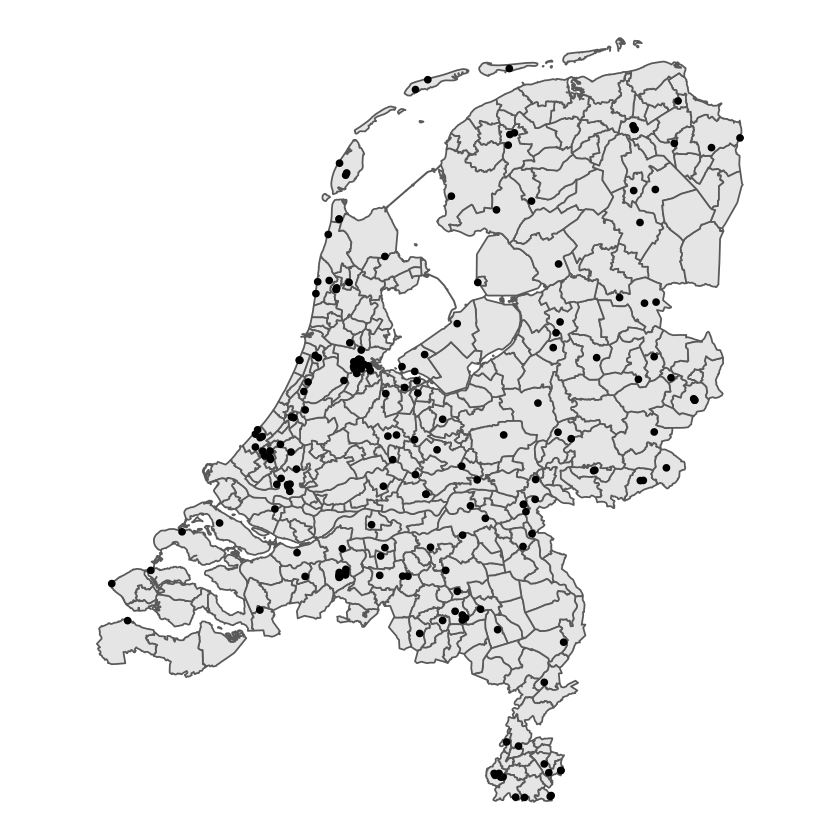

In [ ]:
municipalBoundaries %>% 
  ggplot() +
  geom_sf() +
  geom_sf(data = locations_df) +
  theme_void()
